# CSC421 Assignment 1 Search, and CSP 

This assignment notebook explores topics covered in **Chapter 3 - Searching** and **Chapter 6 - Constraint Satisfaction Problems** from the book *Artificial Intelligence: A Modern Approach.* The code provided is based on parts of the aima-code repository but has been adapted, modified and simplified for the purposes of the assignment. The notebook is self-contained and other than importing a few common packages you don't need to access any additional code. 

You are welcome (and it can be educational) to look at the code at the aima-code repository and other code resources you can find on the web or ask ChatGPT. However, make sure you understand any code that you incorporate and submit. Plagiarism checking will be done. Additionally, at the teaching team's discretion, a random subset of students may be examined in person and asked questions about the code submitted. Failure to understand the submitted code will result in a 0 grade for the entire assignment. 

The assignment structure is as follows: 

1. Search (Basic) -  Add a connection to the Romania map, try out search, print paths
2. Search (Basic) -  Return frontier lengths
3. Search (Expected) - RandomSearch  
4. Search (Expected) - Change the grid problem to 4 directions and modulo movement 
5. Search (Expected) - Landgrid problem and manhattan distance
6. CSP (Basic): Basic CSP for a map of Australia with unitary constraint  
7. CSP (Advanced): Type inference toy example as CSP  

**IMPORTANT:** An assignment through Brightspace will provide the complete submission details. You will be required to submit this notebook. For working on the assignment, I recommend using the Jupyter-lab interface as it supports interactive development and is helpful for visualizations and plots. Please make sure the notebook you submit is clean, it should not be so heavily modified with debugging, figures, etc. that it becomes difficult to mark. Make sure that the notebook you submit is functioning and that you have used best practices in ensuring that (reloading the notebook, clearing history/memory, HINT: you may need to force refresh your browser (e.g., crtl+F5), ensuring that the submission is actually what you intend to submit for marking). We will **NOT** accept changes after the deadline if you have made a submission mistake.

In [2]:
## ABSTRACT PROBLEM CLASS 

%matplotlib inline
import matplotlib.pyplot as plt
import random
import heapq
import math
import sys
from collections import defaultdict, deque, Counter
from itertools import combinations

class Problem(object):
    """The abstract class for a formal problem. A new domain subclasses this,
    overriding `actions` and `results`, and perhaps other methods.
    The default heuristic is 0 and the default action cost is 1 for all states.
    When yiou create an instance of a subclass, specify `initial`, and `goal` states 
    (or give an `is_goal` method) and perhaps other keyword args for the subclass."""

    def __init__(self, initial=None, goal=None, **kwds): 
        self.__dict__.update(initial=initial, goal=goal, **kwds) 
        
    def actions(self, state):        raise NotImplementedError
    def result(self, state, action): raise NotImplementedError
    def is_goal(self, state):        return state == self.goal
    def action_cost(self, s, a, s1): return 1
    def h(self, node):               return 0
    
    def __str__(self):
        return '{}({!r}, {!r})'.format(
            type(self).__name__, self.initial, self.goal)

class Node:
    "A Node in a search tree."
    def __init__(self, state, parent=None, action=None, path_cost=0):
        self.__dict__.update(state=state, parent=parent, action=action, path_cost=path_cost)

    def __repr__(self): return '<{}>'.format(self.state)
    def __len__(self): return 0 if self.parent is None else (1 + len(self.parent))
    def __lt__(self, other): return self.path_cost < other.path_cost
    
failure = Node('failure', path_cost=math.inf) # Indicates an algorithm couldn't find a solution.
cutoff  = Node('cutoff',  path_cost=math.inf) # Indicates iterative deepening search was cut off.
       
def expand(problem, node):
    "Expand a node, generating the children nodes."
    s = node.state
    for action in problem.actions(s):
        s1 = problem.result(s, action)
        cost = node.path_cost + problem.action_cost(s, action, s1)
        yield Node(s1, node, action, cost)
        
def path_actions(node):
    "The sequence of actions to get to this node."
    if node.parent is None:
        return []  
    return path_actions(node.parent) + [node.action]

def path_states(node):
    "The sequence of states to get to this node."
    if node in (cutoff, failure, None): 
        return []
    return path_states(node.parent) + [node.state]

In [3]:
# PriorityQueue - note 
# there is a small difference from the 
# book implementation in order to ensure 
# sorting stability 

class PriorityQueue:
    """A queue in which the item with minimum f(item) is always popped first."""

    def __init__(self, items=(), key=lambda x: x): 
        self.key = key
        self.items = [] # a heap of (score, item) pairs
        self.item_count = 0 
        for item in items:
            self.add(item)
         
    def add(self, item):
        """Add item to the queuez."""
        pair = ((self.key(item),self.item_count), item)
        heapq.heappush(self.items, pair)
        self.item_count+=1  

    def pop(self):
        """Pop and return the item with min f(item) value."""
        return heapq.heappop(self.items)[1]
    
    def top(self): return self.items[0][1]

    def get_items(self): 
        return self.items.copy() 

    def __len__(self): return len(self.items)

In [4]:
# Different search algorithms 
# defined by appropriate definition of priorities 


def best_first_search(problem, f):
    "Search nodes with minimum f(node) value first."
    node = Node(problem.initial)
    frontier = PriorityQueue([node], key=f)
    reached = {problem.initial: node}
    frontiers = [] 
    while frontier:
        frontier_items = frontier.get_items()
        frontiers.append(frontier_items)
        node = frontier.pop()
        
        if problem.is_goal(node.state):
            return (node,reached,frontiers)
        for child in expand(problem, node):
            s = child.state
            if s not in reached or child.path_cost < reached[s].path_cost:
                reached[s] = child
                frontier.add(child)
        
    return (failure, reached, frontiers)

def g(n): return n.path_cost

def astar_search(problem, h=None):
    """Search nodes with minimum f(n) = g(n) + h(n)."""
    h = h or problem.h
    return best_first_search(problem, f=lambda n: g(n) + h(n))
        
def greedy_bfs(problem, h=None):
    """Search nodes with minimum h(n)."""
    h = h or problem.h
    return best_first_search(problem, f=h)

def uniform_cost_search(problem):
    "Search nodes with minimum path cost first."
    return best_first_search(problem, f=g)

def breadth_first_bfs(problem):
    "Search shallowest nodes in the search tree first; using best-first."
    return best_first_search(problem, f=len)


# QUESTION 1 Search (Basic) - 5 points

This question looks at how the RouteProblem works using the classic map of Romania. 
1. Create a copy of the map of Romania specified below and call it romania_new
2. Add a connection from Sibiu to Bucharest with a cost of 280 in romania_new
3. Create a new RouteProblem called r_new using the romania_new map
4. Run **BreadthFirstSearch** search for the pair Arad(initial state) to Bucharest (goal state) for the new map **romania_new** print the solution path
5. Run **UniformCostSearch** search for the pair Arad(initial state) to Bucharest (goal state) for the new map **romania_new** print the solution path

*Note an example route problems, search call, and printing is provided below*

In [5]:
class RouteProblem(Problem):
    """A problem to find a route between locations on a `Map`.
    Create a problem with RouteProblem(start, goal, map=Map(...)}).
    States are the vertexes in the Map graph; actions are destination states."""
    
    def actions(self, state): 
        """The places neighboring `state`."""
        return self.map.neighbors[state]
    
    def result(self, state, action):
        """Go to the `action` place, if the map says that is possible."""
        return action if action in self.map.neighbors[state] else state
    
    def action_cost(self, s, action, s1):
        """The distance (cost) to go from s to s1."""
        return self.map.distances[s, s1]
    
    def h(self, node):
        "Straight-line distance between state and the goal."
        locs = self.map.locations
        return straight_line_distance(locs[node.state], locs[self.goal])
    
    
def straight_line_distance(A, B):
    "Straight-line distance between two points."
    return sum(abs(a - b)**2 for (a, b) in zip(A, B)) ** 0.5

In [6]:
class Map:
    """A map of places in a 2D world: a graph with vertexes and links between them. 
    In `Map(links, locations)`, `links` can be either [(v1, v2)...] pairs, 
    or a {(v1, v2): distance...} dict. Optional `locations` can be {v1: (x, y)} 
    If `directed=False` then for every (v1, v2) link, we add a (v2, v1) link."""

    def __init__(self, links, locations=None, directed=False):
        if not hasattr(links, 'items'): # Distances are 1 by default
            links = {link: 1 for link in links}
        if not directed:
            for (v1, v2) in list(links):
                links[v2, v1] = links[v1, v2]
        self.distances = links
        self.neighbors = multimap(links)
        self.locations = locations or defaultdict(lambda: (0, 0))

        
def multimap(pairs) -> dict:
    "Given (key, val) pairs, make a dict of {key: [val,...]}."
    result = defaultdict(list)
    for key, val in pairs:
        result[key].append(val)
    return result

In [7]:
# Some specific RouteProblems

romania = Map(
    {('O', 'Z'):  71, ('O', 'S'): 151, ('A', 'Z'): 75, ('A', 'S'): 140, ('A', 'T'): 118, 
     ('L', 'T'): 111, ('L', 'M'):  70, ('D', 'M'): 75, ('C', 'D'): 120, ('C', 'R'): 146, 
     ('C', 'P'): 138, ('R', 'S'):  80, ('F', 'S'): 99, ('B', 'F'): 211, ('B', 'P'): 101, 
     ('B', 'G'):  90, ('B', 'U'):  85, ('H', 'U'): 98, ('E', 'H'):  86, ('U', 'V'): 142, 
     ('I', 'V'):  92, ('I', 'N'):  87, ('P', 'R'): 97},
    {'A': ( 76, 497), 'B': (400, 327), 'C': (246, 285), 'D': (160, 296), 'E': (558, 294), 
     'F': (285, 460), 'G': (368, 257), 'H': (548, 355), 'I': (488, 535), 'L': (162, 379),
     'M': (160, 343), 'N': (407, 561), 'O': (117, 580), 'P': (311, 372), 'R': (227, 412),
     'S': (187, 463), 'T': ( 83, 414), 'U': (471, 363), 'V': (535, 473), 'Z': (92, 539)})


r0 = RouteProblem('A', 'A', map=romania)
r1 = RouteProblem('A', 'B', map=romania)
r2 = RouteProblem('N', 'L', map=romania)
r3 = RouteProblem('E', 'T', map=romania)
r4 = RouteProblem('O', 'M', map=romania)
s1, reached, frontiers = uniform_cost_search(r1)
print(path_states(s1))
# the answer should be ['A', 'S', 'R', 'P', 'B']

['A', 'S', 'R', 'P', 'B']


In [8]:
# Your Q1 ANSWER GOES HERE  
#This question looks at how the RouteProblem works using the classic map of Romania. 
#1. Create a copy of the map of Romania specified below and call it romania_new
#2. Add a connection from Sibiu to Bucharest with a cost of 280 in romania_new
#3. Create a new RouteProblem called r_new using the romania_new map
#4. Run **BreadthFirstSearch** search for the pair Arad(initial state) to Bucharest (goal state) for the new map **romania_new** print the solution path
#5. Run **UniformCostSearch** search for the pair Arad(initial state) to Bucharest (goal state) for the new map **romania_new** print the solution path
romania_new = Map(
    {('O', 'Z'):  71, ('O', 'S'): 151, ('A', 'Z'): 75, ('A', 'S'): 140, ('A', 'T'): 118, 
     ('L', 'T'): 111, ('L', 'M'):  70, ('D', 'M'): 75, ('C', 'D'): 120, ('C', 'R'): 146, 
     ('C', 'P'): 138, ('R', 'S'):  80, ('F', 'S'): 99, ('B', 'F'): 211, ('B', 'P'): 101, 
     ('B', 'G'):  90, ('B', 'U'):  85, ('H', 'U'): 98, ('E', 'H'):  86, ('U', 'V'): 142, 
     ('I', 'V'):  92, ('I', 'N'):  87, ('P', 'R'): 97, ('B', 'S'): 280},
    {'A': ( 76, 497), 'B': (400, 327), 'C': (246, 285), 'D': (160, 296), 'E': (558, 294), 
     'F': (285, 460), 'G': (368, 257), 'H': (548, 355), 'I': (488, 535), 'L': (162, 379),
     'M': (160, 343), 'N': (407, 561), 'O': (117, 580), 'P': (311, 372), 'R': (227, 412),
     'S': (187, 463), 'T': ( 83, 414), 'U': (471, 363), 'V': (535, 473), 'Z': (92, 539)})

#print(romania.distances)
r_new = RouteProblem('A', 'B', map=romania_new)
s_new, reached, frontiers = breadth_first_bfs(r_new)
print(path_states(s_new))
s_new, reached, frontiers = uniform_cost_search(r_new)
print(path_states(s_new))


['A', 'S', 'B']
['A', 'S', 'R', 'P', 'B']


# QUESTION 2 Search (Basic) - 5 points

1. Implement the function frontier_lengths.  This function should return a list with the lengths of the frontier during the operation of the search algorithm given the frontier list.
2. Now run this function on the output of **uniform_cost_search** for problems r0, r1, r2, and r4 above AND print the object returned (see example below).
3. Now run this function on the output of **uniform_cost_search** for problems r_new above AND print the object returned (see example below).
4. Now run this function on the output of **breadth_first_bfs** for problems r0, r1, r2, and r4 above AND print the object returned (see example below).
5. Now run this function on the output of **breadth_first_bfs** for problems r_new above AND print the object returned (see example below).

In [9]:
# Your Q2 PART 1 ANSWER GOES HERE
# 1. Implement the function frontier_lengths.  This function should return a list with the lengths of the frontier during the operation of the search algorithm given the frontier list.
# 2. Now run this function on the output of **uniform_cost_search** for problems r0, r1, r2, and r4 above AND print the object returned (see example below).
# 3. Now run this function on the output of **uniform_cost_search** for problems r_new above AND print the object returned (see example below).
# 4. Now run this function on the output of **breadth_first_bfs** for problems r0, r1, r2, and r4 above AND print the object returned (see example below).
# 5. Now run this function on the output of **breadth_first_bfs** for problems r_new above AND print the object returned (see example below).

def frontier_lengths(frontiers):
    lengths = []
    for frontier in frontiers:
        lengths.append(len(frontier))
    return lengths
# An example to illustrate functionality and printing output
s1, reached, frontiers = uniform_cost_search(r1)
print(frontier_lengths(frontiers))

# the answer should be 
# [1, 3, 3, 3, 4, 3, 4, 4, 4, 4, 4, 3, 2]
# [1, 3, 3, 3, 4, 3, 4, 4, 4, 4, 4, 3, 2]

[1, 3, 3, 3, 4, 3, 4, 4, 4, 4, 4, 3, 2]


In [10]:
# Q2 PART 2 ANSWER GOES HERE (search and printing of frontier)
s0, reached, frontiers = uniform_cost_search(r0)
print(frontier_lengths(frontiers))
s1, reached, frontiers = uniform_cost_search(r1)
print(frontier_lengths(frontiers))
s2, reached, frontiers = uniform_cost_search(r2)
print(frontier_lengths(frontiers))
s4, reached, frontiers = uniform_cost_search(r4)
print(frontier_lengths(frontiers))


[1]
[1, 3, 3, 3, 4, 3, 4, 4, 4, 4, 4, 3, 2]
[1, 1, 1, 1, 2, 4, 4, 3, 2, 3, 3, 2, 2, 3, 3, 4, 3, 3, 2]
[1, 2, 2, 2, 3, 4, 4, 4, 4, 4, 4, 5]


In [11]:
# Q2 PART 3 ANSWER GOES HERE (search and printing of frontier)
s_new, reached, frontiers = uniform_cost_search(r_new)
print(frontier_lengths(frontiers))


[1, 3, 3, 3, 5, 4, 5, 5, 4, 4, 4, 3, 2]


In [12]:
# Q2 PART 4 ANSWER GOES HERE (search and printing of frontier)
s0, reached, frontiers = breadth_first_bfs(r0)
print(frontier_lengths(frontiers))
s1, reached, frontiers = breadth_first_bfs(r1)
print(frontier_lengths(frontiers))
s2, reached, frontiers = breadth_first_bfs(r2)
print(frontier_lengths(frontiers))
s4, reached, frontiers = breadth_first_bfs(r4)
print(frontier_lengths(frontiers))


[1]
[1, 3, 3, 4, 4, 3, 4, 4, 4, 4, 4]
[1, 1, 1, 1, 2, 4, 4, 4, 5, 4, 3, 4, 4, 4, 4, 5, 6, 6, 5, 4, 4, 4, 5, 5]
[1, 2, 2, 3, 3, 4, 4, 4, 4, 4, 5, 5, 4, 5, 4, 5]


In [13]:
# Q2 PART 5 ANSWER GOES HERE (search and printing of frontier)
s_new, reached, frontiers = breadth_first_bfs(r_new)
print(frontier_lengths(frontiers))


[1, 3, 3, 5, 5, 4, 5, 4]


# QUESTION 3 Search (Expected) - 4 points

1. Write your own search algorithm called **random_search**. In this search algorithm, the node selected for expansion is selected randomly from the frontier (with uniform probability among the possible nodes). Do not modify *best_first_search* but rather assign random priorities to each node. The random priorities should be between 0.0 and 1.0. HINT: See the imports at the top of this notebook, python has the ability to do this in the *random* package.
2. You must use **random.seed(10.0)** to ensure reproducibility.
3. Use the new algorithm to run it for the r_new pair (Arad to Bucharest) on the **romania_new** map.
4. Run frontier_lengths from above on this output.

In [14]:
# Q3  Part 1 and 2 ANSWER GOES HERE (random_search)
#1. Write your own search algorithm called **random_search**. In this search algorithm, the node selected for expansion is selected randomly from the frontier (with uniform probability among the possible nodes). Do not modify *best_first_search* but rather assign random priorities to each node. The random priorities should be between 0.0 and 1.0. HINT: See the imports at the top of this notebook, python has the ability to do this in the *random* package.
#2. You must use **random.seed(10.0)** to ensure reproducibility.

def random_search(problem):
    random.seed(10.0)
    #print(random.uniform(0, 1))
    return best_first_search(problem, f=lambda n: random.uniform(0, 1))

In [15]:
# Q3  Part 3 and 4 ANSWER GOES HERE (search and print)
#3. Use the new algorithm to run it for the r_new pair (Arad to Bucharest) on the **romania_new** map.
#4. Run frontier_lengths from above on this output.
r_new = RouteProblem('A', 'B', map=romania_new)
s_new, reached, frontiers = random_search(r_new)
print(frontier_lengths(frontiers))



[1, 3, 3, 3, 5, 4]


# QUESTION 4 Search (Expected) - 4 points

1. Create a new class of search problems called **GridProblemMod** by copying and renaming the **GridProblem** class below appropriately.
2. The two modifications that you will need to implement for **GridProblemMod** in this question are to restrict the directions the agent can move to so that no diagonal movement is allowed i.e. only up/right/down/left movement using that order.
3. Unlike the original **GridProblem**, in this case, the grid will be finite. Add a parameter to the __init__ method called size that determines the size $N$ of the land grid which is a $N$ by $N$ square.
4. The movement should implement wrap-around using modulo arithmetic i.e if the agent in a grid of size $10$ is in square $(0,5)$ and the action $(-1,5)$ is applied, then the agent should move to square $(9,5)$. Another way to think of it is that when the agent reaches the boundary of the land grid they **jump** to the other side. Yet, another way of thinking of this is that the world becomes a torus!

*The path shown below demonstrates this wrap-around behaviour.*


In [16]:
class GridProblem(Problem):
    """Finding a path on a 2D grid with obstacles. Obstacles are (x, y) cells."""

    def __init__(self, initial=(15, 30), goal=(130, 30), obstacles=(), **kwds):
        Problem.__init__(self, initial=initial, goal=goal, 
                         obstacles=set(obstacles) - {initial, goal}, **kwds)

    directions = [(-1, -1), (0, -1), (1, -1),
                  (-1, 0),           (1,  0),
                  (-1, +1), (0, +1), (1, +1)]
    
    def action_cost(self, s, action, s1): return straight_line_distance(s, s1)
    
    def h(self, node): return straight_line_distance(node.state, self.goal)
                  
    def result(self, state, action): 
        "Both states and actions are represented by (x, y) pairs."
        return action if action not in self.obstacles else state
    
    
    def actions(self, state):
        """You can move one cell in any of `directions` to a non-obstacle cell."""
        x, y = state
        return {(x + dx, y + dy) for (dx, dy) in self.directions} - self.obstacles

def straight_line_distance(A, B):
    "Straight-line distance between two points."
    return sum(abs(a - b)**2 for (a, b) in zip(A, B)) ** 0.5

def transpose(matrix): return list(zip(*matrix))


In [17]:
# question 4 ANSWER GOES HERE 
# add your GridProblemMod class 
# and then check that the code provided works 
# and produces the desired output 
# you can add some check of your own to 
# see how things work 
#1. Create a new class of search problems called **GridProblemMod** by copying and renaming the **GridProblem** class below appropriately.
#2. The two modifications that you will need to implement for **GridProblemMod** in this question are to restrict the directions the agent can move to so that no diagonal movement is allowed i.e. only up/right/down/left movement using that order.
#3. Unlike the original **GridProblem**, in this case, the grid will be finite. Add a parameter to the __init__ method called size that determines the size $N$ of the land grid which is a $N$ by $N$ square.
#4. The movement should implement wrap-around using modulo arithmetic i.e if the agent in a grid of size $10$ is in square $(0,5)$ and the action $(-1,5)$ is applied, then the agent should move to square $(9,5)$. Another way to think of it is that when the agent reaches the boundary of the land grid they **jump** to the other side. Yet, another way of thinking of this is that the world becomes a torus!
class GridProblemMod(Problem):
    """Finding a path on a 2D grid with obstacles. Obstacles are (x, y) cells."""

    def __init__(self, initial=(15, 30), goal=(130, 30), obstacles=(), size=10, **kwds):
        self.size = size # Added parameter for the size of the land grid
        Problem.__init__(self, initial=initial, goal=goal, 
                         obstacles=set(obstacles) - {initial, goal}, **kwds)

    directions = [(0, -1), (+1, 0),
                  (-1, 0), (0, +1)] # Restricting to up, right, down, left
    
    def action_cost(self, s, action, s1): return straight_line_distance(s, s1)
    
    def h(self, node): return straight_line_distance(node.state, self.goal)
                  
    def result(self, state, action): 
        "Both states and actions are represented by (x, y) pairs."
        x, y = action if action not in self.obstacles else state
        # Implementing wrap-around using modulo arithmetic
        new_x = (x + self.size) % self.size
        new_y = (y + self.size) % self.size
        return (new_x, new_y)
    
    def actions(self, state):
        """You can move one cell in any of `directions` to a non-obstacle cell."""
        x, y = state
        return {(x + dx, y + dy) for (dx, dy) in self.directions} - self.obstacles

def straight_line_distance(A, B):
    "Straight-line distance between two points."
    return sum(abs(a - b)**2 for (a, b) in zip(A, B)) ** 0.5

def transpose(matrix): return list(zip(*matrix))

g1 = GridProblemMod(initial = (2,2), goal = (7,6), size=10)
(bfs_g1, reached, frontiers) = breadth_first_bfs(g1)
print(path_states(bfs_g1))
# desired answer 
# [(2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (1, 6), (0, 6), (9, 6), (8, 6), (7, 6)]

[(2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (1, 6), (0, 6), (9, 6), (8, 6), (7, 6)]


# QUESTION 5 Search (Expected) - 4 points

1. Create a new class of search problems called **LandGridProblem** by copying and renaming the **GridProblemMod** class you completed in the previous question.
2. Each location on the LandGrid has an associated number representing the "cost" of going through that location. Grass corresponds to 1, hills correspond to 2, and mountains correspond to 3. This is similar to tile-based board games such as Settlers of Catan or computer games such as Civilization.
3. You will need to modify the action_cost method to take into account the land cost. So if a path contains two grass squares, three hills, and one mountain the total path cost will be $2 * 1 + 3 * 2 + 1 * 3 = 10$.
4. Add a **Manhattan distance** heuristic to your implementation. The **Manhattan distance** between two points $(x_1, y_1)$ and $(x_2, y_2)$ is defined as $|x_2 - x_1| + |y_2 - y_1|$. The choice of heuristic should be specified by an argument to the LandGridProblem, how this is done can be seen in the init function provided below. See tests below where we use A* and greedy to trigger use of the heuristics!

For example: 
```
d4_h1 = LandgridProblem(initial = (2,2), goal=(7,6), land_grid = land_grid4, heuristic='straight')
d4_h2 = LandgridProblem(initial = (2,2), goal=(7,6), land_grid = land_grid4, heuristic='manhattan')
```

Some code for creating, printing, and plotting land grids is provided below. 

**IMPORTANT:**
Here is the __init__ function you will need to use. 

```
def __init__(self, initial=(2, 2), goal=(4, 4), land_grid=[],heuristic="straight",**kwds):
        size = len(land_grid)
        self.size = size 
        self.heuristic = heuristic 
        Problem.__init__(self, initial=initial, goal=goal, land_grid = land_grid, size = size, heuristic=heuristic, **kwds)
```

In [18]:
land_grid1 = [[1,1,2,3,3],[1,2,1,3,1],[1,1,3,1,1],[2,2,2,3,3],[3,1,1,1,1]]
land_grid2 = [[1,1,1,1,1],[1,1,1,1,1],[1,1,1,1,1],[1,1,1,1,1],[1,1,1,1,1]]

def create_uniform_land_grid(n): 
    column = [1] * n
    grid = [column] * n 
    return grid 

def create_random_land_grid(n): 
    matrix = [] 
    random.seed(30)
    for i in range(0,n): 
        row = [] 
        for i in range(0,n): 
            row.append(random.randint(1, 3))
        matrix.append(row)
    return matrix 
    
land_grid3 = create_uniform_land_grid(10) 
land_grid4 = create_random_land_grid(10)

print(land_grid4)

[[3, 2, 3, 1, 3, 3, 1, 2, 1, 2], [2, 3, 1, 1, 2, 1, 3, 1, 1, 1], [1, 3, 3, 2, 3, 2, 3, 1, 2, 1], [1, 3, 3, 2, 2, 3, 1, 3, 2, 3], [3, 1, 3, 2, 2, 1, 2, 2, 2, 3], [1, 1, 1, 3, 2, 1, 1, 2, 3, 3], [2, 1, 3, 3, 1, 2, 3, 2, 3, 2], [3, 2, 3, 2, 1, 1, 3, 1, 2, 2], [2, 2, 2, 3, 2, 3, 3, 1, 3, 1], [1, 3, 2, 2, 3, 1, 1, 2, 2, 2]]


In [45]:
# 1. Create a new class of search problems called **LandGridProblem** by copying and renaming the **GridProblemMod** class you completed in the previous question.
# 2. Each location on the LandGrid has an associated number representing the "cost" of going through that location. Grass corresponds to 1, hills correspond to 2, and mountains correspond to 3. This is similar to tile-based board games such as Settlers of Catan or computer games such as Civilization.
# 3. You will need to modify the action_cost method to take into account the land cost. So if a path contains two grass squares, three hills, and one mountain the total path cost will be $2 * 1 + 3 * 2 + 1 * 3 = 10$.
# 4. Add a **Manhattan distance** heuristic to your implementation. The **Manhattan distance** between two points $(x_1, y_1)$ and $(x_2, y_2)$ is defined as $|x_2 - x_1| + |y_2 - y_1|$. The choice of heuristic should be specified by an argument to the LandGridProblem, how this is done can be seen in the init function provided below. See tests below where we use A* and greedy to trigger use of the heuristics!

# For example: 
# ```
# d4_h1 = LandgridProblem(initial = (2,2), goal=(7,6), land_grid = land_grid4, heuristic='straight')
# d4_h2 = LandgridProblem(initial = (2,2), goal=(7,6), land_grid = land_grid4, heuristic='manhattan')
# ```

# QUESTION 5 ANSWER GOES HERE 
class LandgridProblem(Problem):

    def __init__(self, initial=(2, 2), goal=(4, 4), land_grid=[],heuristic="straight",**kwds):
        size = len(land_grid)
        self.size = size 
        self.heuristic = heuristic 
        Problem.__init__(self, initial=initial, goal=goal, land_grid = land_grid, size = size, heuristic=heuristic, **kwds)

    directions = [(0, -1), (+1, 0),
                  (-1, 0), (0, +1)] # Restricting to up, right, down, left
    
    #You will need to modify the action_cost method to take into account the land cost. So if a path contains two grass squares, three hills, and one mountain the total path cost will be $2 * 1 + 3 * 2 + 1 * 3 = 10$.
    def action_cost(self, s, action, s1):
        return self.land_grid[s1[0]][s1[1]]
    
    def h(self, node): 
        if self.heuristic == "straight": 
            return straight_line_distance(node.state, self.goal)
        elif self.heuristic == "manhattan": 
            return manhattan_distance(node.state, self.goal)
        else: 
            return 0
                  
    def result(self, state, action): 
        "Both states and actions are represented by (x, y) pairs."
        x, y = action 
        # Implementing wrap-around using modulo arithmetic
        new_x = (x + self.size) % self.size
        new_y = (y + self.size) % self.size
        return (new_x, new_y)
    
    def actions(self, state):
        """You can move one cell in any of `directions` to a non-obstacle cell. (not checking obstacles)"""
        x, y = state
        return {(x + dx, y + dy) for (dx, dy) in self.directions} 

def straight_line_distance(A, B):
    "Straight-line distance between two points."
    return sum(abs(a - b)**2 for (a, b) in zip(A, B)) ** 0.5

def manhattan_distance(A, B):
    "Manhattan distance between two points."
    return sum(abs(a - b) for (a, b) in zip(A, B))

def transpose(matrix): return list(zip(*matrix))

In [46]:
def plot_grid_problem(grid, solution, reached=(), title='Search', show=True):
    "Use matplotlib to plot the grid, obstacles, solution, and reached."
    grass_points = [] 
    hill_points = [] 
    mountain_points = [] 
    for i in range(0,grid.size): 
        for j in range(0,grid.size): 
            if (grid.land_grid[i][j] == 1): 
                grass_points.append((i,j))
            elif (grid.land_grid[i][j] == 2): 
                hill_points.append((i,j))
            elif (grid.land_grid[i][j] == 3): 
                mountain_points.append((i,j))
    
    nlocations =  grid.size
    plt.figure(figsize=(5, 5))
    plt.axis('on'); 
    plt.xlim((-0.5,nlocations-0.5))
    plt.ylim((-0.5,nlocations-0.5))
    if (grass_points):
        plt.scatter(*transpose(grass_points), (250 / nlocations) **2, marker='s', c='green')
    if (hill_points): 
        plt.scatter(*transpose(hill_points), (250 / nlocations) **2, marker='s', c='yellow')
    if (mountain_points): 
        plt.scatter(*transpose(mountain_points), (250 / nlocations) **2, marker='s', c='black')
    plt.scatter(*transpose(reached), (50/nlocations)**2, marker='o', c='blue')
    plt.scatter(*transpose(path_states(solution)), (100 / nlocations) **2,marker='s', c='red')
    plt.scatter(*transpose([grid.initial]), (50/nlocations)**2, marker='D', c='white')
    plt.scatter(*transpose([grid.goal]), (125/nlocations)**2, marker='*', c='white')
    if show: plt.show()
    print('{} {} search: {:.1f} path cost, {:,d} states reached'
          .format(' ' * 10, title, solution.path_cost, len(reached)))

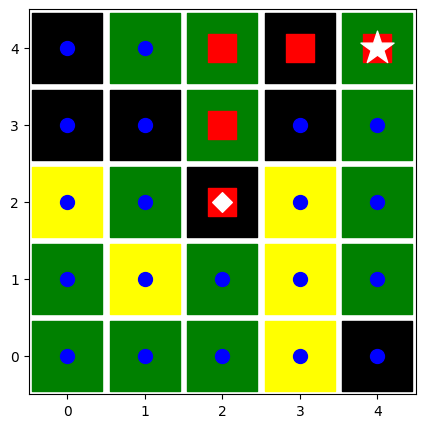

           D1 BFS search: 6.0 path cost, 25 states reached


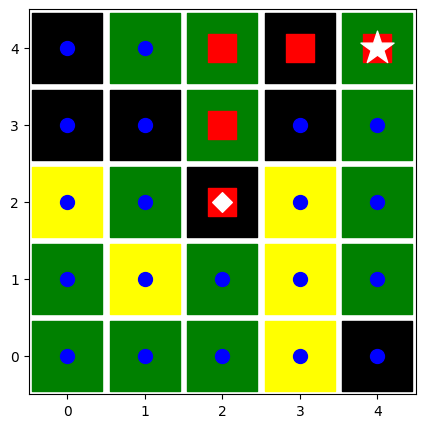

           D1 Uniform search: 6.0 path cost, 25 states reached


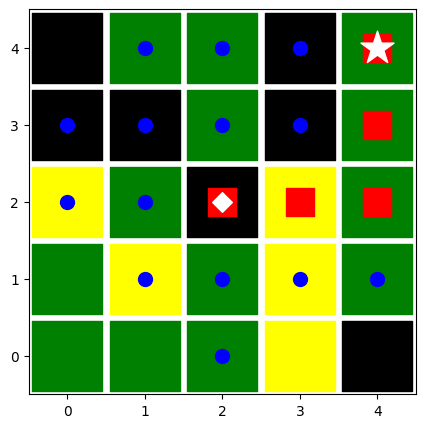

           D1 A* search search: 5.0 path cost, 19 states reached


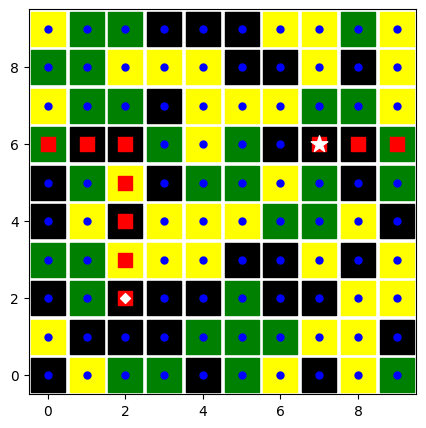

           D4 BFS search: 21.0 path cost, 100 states reached


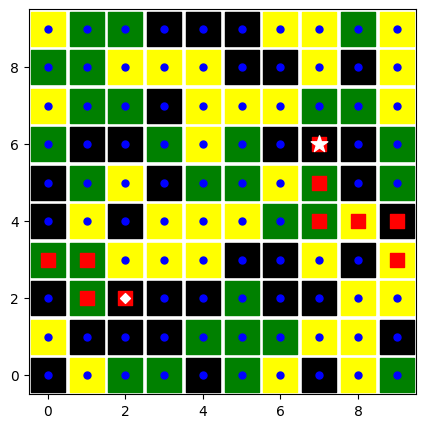

           D4 UCF search: 15.0 path cost, 100 states reached


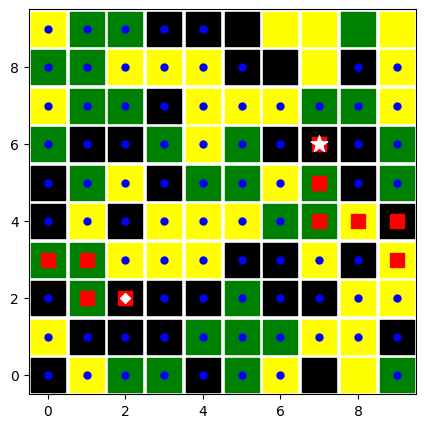

           D4 A* search: 15.0 path cost, 91 states reached


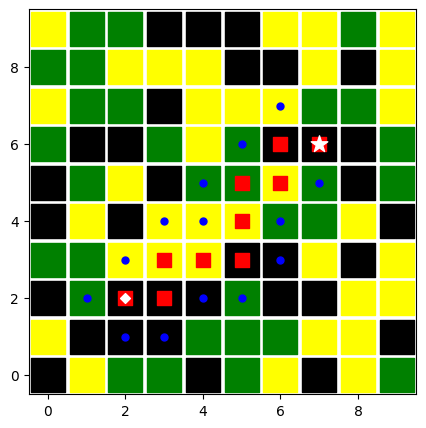

           D4 Greedy search: 21.0 path cost, 24 states reached


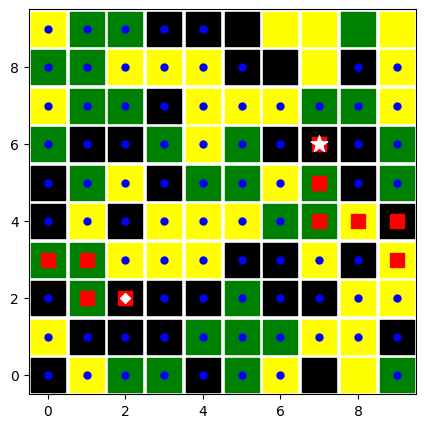

           D4 A* Straight search: 15.0 path cost, 91 states reached


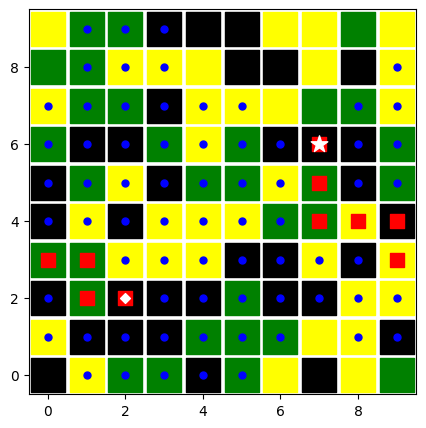

           D4 A* Manhattan search: 15.0 path cost, 79 states reached


In [50]:
# This code will not work until you have implemented appropriately the LandGridProblem class 
# These tests must pass!

d1 = LandgridProblem(initial = (2,2), land_grid = land_grid1)
(bfs_d1, reached, frontiers) = breadth_first_bfs(d1)
plot_grid_problem(d1, bfs_d1, reached, title='D1 BFS', show=True)
(ucs_d1, reached, frontiers) = uniform_cost_search(d1) 
plot_grid_problem(d1, bfs_d1, reached, title='D1 Uniform', show=True)
(ass_d1, reached, frontiers) = astar_search(d1)
plot_grid_problem(d1, ass_d1, reached, title='D1 A* search', show=True)


d4 = LandgridProblem(initial = (2,2), goal=(7,6), land_grid = land_grid4)
(bfs_d4, reached, frontiers) = breadth_first_bfs(d4)
plot_grid_problem(d4, bfs_d4, reached, title='D4 BFS', show=True)
(ucs_d4, reached, frontiers) = uniform_cost_search(d4)
plot_grid_problem(d4, ucs_d4, reached, title='D4 UCF', show=True)
(ass_d4, reached, frontiers) = astar_search(d4)
plot_grid_problem(d4, ass_d4, reached, title='D4 A*', show=True)
(grs_d4, reached, frontiers) = greedy_bfs(d4)
plot_grid_problem(d4, grs_d4, reached, title='D4 Greedy', show=True)


d4_h1 = LandgridProblem(initial = (2,2), goal=(7,6), land_grid = land_grid4, heuristic='straight')
(bfs_d4_h1, reached, frontiers) = astar_search(d4_h1)
plot_grid_problem(d4_h1, bfs_d4_h1, reached, title='D4 A* Straight', show=True)

d4_h2 = LandgridProblem(initial = (2,2), goal=(7,6), land_grid = land_grid4, heuristic='manhattan')
(bfs_d4_h2, reached, frontiers) = astar_search(d4_h2)
plot_grid_problem(d4_h2, bfs_d4_h2, reached, title='D4 A* Manhattan', show=True)

# QUESTION 6 CSP (Expected) - 4 points

Let's look at a simple basic implementation of recursive backtracking search for solving CSP problems. 

In [ ]:
def isComplete(assignment):
    return None not in (assignment.values())

def select_unassigned_variable(variables, assignment):
    for var in variables:
        if assignment[var] is None:
            return var

def is_consistent(assignment, constraints):
    for constraint_violated in constraints:
        if constraint_violated(assignment):
          return False
    return True

def init_assignment(csp):
    assignment = {}
    for var in csp["VARIABLES"]:
        assignment[var] = None
    return assignment

def add_constraint(csp, constraint): 
    csp['CONSTRAINTS'].append(constraint)
    
def recursive_backtracking(assignment, csp):
    if isComplete(assignment):
        return assignment
    var = select_unassigned_variable(csp["VARIABLES"], assignment)
    for value in csp["DOMAINS"]:
        assignment[var] = value
        if is_consistent(assignment, csp["CONSTRAINTS"]):
            result = recursive_backtracking(assignment, csp)
            if result != "FAILURE":
                return result
        assignment[var] = None
    return "FAILURE"


def binary_constraint(var_pair, violations):
    (v1,v2) = var_pair
    return lambda asmt: (asmt[v1], asmt[v2]) in violations


We can use this implementation to solve the Australia map colouring problem. Before working on this question make sure you understand how the code works. 

1. Add a unary constraint function. Similarly to binary constraint, it should return a function that takes as input an assignment and returns true if the assignment violates the constraint.
2. Show how this new unary constraint can be used to enforce that WA is blue
3. Now in addition to (2), use this new unary constraint to enforce that T is blue in the resulting solution.
4. Now in addition to (3), use this new unary constraint to enforce that NT is also blue in the resulting solution. See below for expected output.

In [ ]:
csp1 = {"VARIABLES": ["WA", "NT", "Q", "NSW", "V", "SA", "T"],
        "DOMAINS": ["red", "green", "blue"],
        "CONSTRAINTS": []}

violations = {('red','red'), ('green','green'), ('blue','blue')}

for (v1,v2) in [('WA', 'NT'), ('WA', 'SA'), 
                ('NT', 'SA'), ('NT', 'Q'), 
                ('SA', 'Q'), ('SA', 'NSW'), 
                ('SA', 'V'),('Q', 'NSW'), 
                ('V', 'T')]: 
    add_constraint(csp1, binary_constraint((v1,v2), violations))


NameError: name 'add_constraint' is not defined

In [ ]:
# Q6 ANSWER GOES HERE

# HINTS:
# 0) define a unary constraint, see binary constrain above
# Repeat
# 1) add constraint to CSP
# 2) recursive backtracking on an initial assignment
# 3) print



# Expected output
# NOTE here the solution should have WA as blue
# Result {'WA': 'blue', 'NT': 'red', 'Q': 'blue', 'NSW': 'red', 'V': 'red', 'SA': 'green', 'T': 'green'}
# NOTE here the solution should have WA as blue and T as blue
# Result {'WA': 'blue', 'NT': 'red', 'Q': 'blue', 'NSW': 'red', 'V': 'red', 'SA': 'green', 'T': 'blue'}
# NOTE this is impossible, so failure!
# Result FAILURE

# QUESTION 7 CSP (Advanced) - 5 points

Type inference is used in programming languages to 
infer the type of variables without explicitly stating it. 
Some examples: 
* x = 1  (we can infer x is an integer because 1 is an integer) 
* y = 1.0 (we can infer y is a float because 1.0 is a float) 
* z = x + y (we can infer z is a float because adding a float 
and an integer results in a float)

Constraint satisfaction problem solvers can be used to perform 
type inference. The variables of the programming languages become the variables of the CSP problem, and the domain of each variable is the types it can have. Constraints are created from the expressions analyzed in order to enforce that the assignment of variables to types is correct. Let's consider a simple example: 

* int I 
* float F 
* X = I 
* Y = X + F 
* Z = X + Y
* W = X + I 

We assume that when two variables are connected using assignment then they are the same type. So X is an integer because I has been declared an integer. The type of the result of adding two integers is an integer, the result of adding two floats is a float but the result of adding an integer and a float has type float. So we know that X is an integer and we add F which is a float therefore Y is a float and similarly Z is also a float.  W is an integer because X and I are integers. 

Notice that we did not declare the types of X, Y, and Z but were able to infer them using the semantics of the equality sign and addition. 

1. Your task for this question is to express this code as a CSP problem and solve it.
2. The result of the CSP will be the inferred types.
3. Each variable (I,F,X,Y,Z,W) will take values from the domain (int, float).
4. Unary constraints can be used for the type declaration and a binary constraint can be used for the assignment expression.
5. You will need to introduce a ternary_constraint method to express the sum expressions. 

In [ ]:
# Q7 ANSWER GOES HERE (modifications to CSP code and definition)



# result = recursive_backtracking(init_assignment(csp1), csp1)
# print('Result', result)
# Result {'I': 'int', 'F': 'float', 'X': 'int', 'Y': 'float', 'Z': 'float', 'W': 'int'}

